# 1. Example Usage with Continuous Treatment Synthetic Data

## 1.1 DGP 
We use the data generating process (DGP) from [here](https://arxiv.org/abs/1806.03467). The DGP is described by the following equations:

\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders and $\beta, \gamma$ have high sparsity.

For this DGP, 
\begin{align}
\theta(x) = \exp(2\cdot x_1).
\end{align}

In [45]:
from _ortho_forest import DMLOrthoForest_test
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLasso
# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression, \
    LogisticRegressionCV

import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
# Treatment effect function
def exp_te(x):
    return np.exp(2*x[0])

In [47]:
# DGP constants
np.random.seed(123)
n = 1000
n_w = 30
support_size = 5
n_x = 1
# Outcome support
support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
def epsilon_sample(n):
    return np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
def eta_sample(n):
    return np.random.uniform(-1, 1, size=n)

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

# ORF parameters and test data
subsample_ratio = 0.3
lambda_reg = np.sqrt(np.log(n_w) / (10 * subsample_ratio * n))
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

In [48]:
def Generate_data_uni(n,d):
    np.random.seed(123)
    n_w = d-1
    support_size = 5
    n_x = 1
    # Outcome support
    support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
    coefs_Y = np.random.uniform(0, 1, size=support_size)
    def epsilon_sample(n):
        return np.random.uniform(-1, 1, size=n)
    # Treatment support
    support_T = support_Y
    coefs_T = np.random.uniform(0, 1, size=support_size)
    def eta_sample(n):
        return np.random.uniform(-1, 1, size=n)
    # Generate controls, covariates, treatments and outcomes
    W = np.random.normal(0, 1, size=(n, n_w))
    X = np.random.uniform(0, 1, size=(n, n_x))
    # Heterogeneous treatment effects
    TE = np.array([exp_te(x_i) for x_i in X])
    T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
    Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
    return Y,T,X,W

In [49]:
def Generate_data_normal(n,d):
    np.random.seed(123)
    n_w = d-1
    support_size = 5
    n_x = 1
    # Outcome support
    support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
    coefs_Y = np.random.uniform(0, 1, size=support_size)
    def epsilon_sample(n):
        return np.random.normal(0, np.sqrt(4), size=n)
    # Treatment support
    support_T = support_Y
    coefs_T = np.random.uniform(0, 1, size=support_size)
    def eta_sample(n):
        return np.random.uniform(-1, 1, size=n)
    # Generate controls, covariates, treatments and outcomes
    W = np.random.normal(0, 1, size=(n, n_w))
    X = np.random.uniform(0, 1, size=(n, n_x))
    # Heterogeneous treatment effects
    TE = np.array([exp_te(x_i) for x_i in X])
    T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
    Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
    return Y,T,X,W

In [50]:
def Generate_data_t(n,d):
    np.random.seed(123)
    n_w = d-1
    support_size = 5
    n_x = 1
    # Outcome support
    support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
    coefs_Y = np.random.uniform(0, 1, size=support_size)
    def epsilon_sample(n):
        return np.random.standard_t(1.5, n)
    # Treatment support
    support_T = support_Y
    coefs_T = np.random.uniform(0, 1, size=support_size)
    def eta_sample(n):
        return np.random.uniform(-1, 1, size=n)
    # Generate controls, covariates, treatments and outcomes
    W = np.random.normal(0, 1, size=(n, n_w))
    X = np.random.uniform(0, 1, size=(n, n_x))
    # Heterogeneous treatment effects
    TE = np.array([exp_te(x_i) for x_i in X])
    T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
    Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
    return Y,T,X,W

In [51]:
def Generate_data_lognor(n,d):
    np.random.seed(123)
    n_w = d-1
    support_size = 5
    n_x = 1
    # Outcome support
    support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
    coefs_Y = np.random.uniform(0, 1, size=support_size)
    def epsilon_sample(n):
        return np.random.lognormal(0, np.sqrt(4), n)
    # Treatment support
    support_T = support_Y
    coefs_T = np.random.uniform(0, 1, size=support_size)
    def eta_sample(n):
        return np.random.uniform(-1, 1, size=n)
    # Generate controls, covariates, treatments and outcomes
    W = np.random.normal(0, 1, size=(n, n_w))
    X = np.random.uniform(0, 1, size=(n, n_x))
    # Heterogeneous treatment effects
    TE = np.array([exp_te(x_i) for x_i in X])
    T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
    Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
    return Y,T,X,W

In [54]:
def Calculate_tau(n,d):
    y,T,X,W = Generate_data_uni(n,d)
    # 计算样本均值
    y_bar = np.mean(y)
    # 计算估计方差
    sigma_hat = np.sqrt(np.mean((y - y_bar) ** 2))
    # 有效样本量 n_eff 的计算
    if d < np.log(n):
        n_eff = n
    else:
        n_eff = n / np.log(d)
    # 计算参数 t
    t = np.log(n)
    # 设置常数 c_tau 和 c_lambda
    c_tau = 1  # 根据需要进行选择：{0.5, 1, 1.5}

    # 计算 tau 和 lambda
    tau = c_tau * sigma_hat * np.sqrt(n_eff / t)
    return tau

In [57]:
Calculate_tau(n=37,d=31)

11.48791108067832

## 1.1 DGP 
We use the data generating process (DGP) from [here](https://arxiv.org/abs/1806.03467). The DGP is described by the following equations:

\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders and $\beta, \gamma$ have high sparsity.

For this DGP, 
\begin{align}
\theta(x) = \exp(2\cdot x_1).
\end{align}

In [36]:
def Calculate_e(Y, T, X, W):
    np.random.seed(123)
    T_res = T - Lasso(alpha=lambda_reg).fit(W, T).predict(W)
    Y_res = Y - Lasso(alpha=lambda_reg).fit(W, Y).predict(W)
    proj = T_res.T @ T_res
    proj_inv = 1/proj
    param_estimate = T_res * proj_inv @ Y_res
    e = Y_res - T_res * param_estimate
    return e

In [70]:
def Plot_e(e):
    # 将 e 从 n*1 转为一维数组（如果需要）
    e = e.flatten()

    # 绘制直方图和核密度估计图
    plt.figure(figsize=(8, 6))
    sns.boxplot(e, color='b', linewidth=2)
    plt.title("Distribution of e")
    plt.xlabel("Value")
    plt.ylabel("Density")

    # 显示图形
    plt.show()

In [38]:
e = Calculate_e(Y, T, X, W)

In [63]:
Y, T, X, W = Generate_data_uni(n=1000, d=31)
e_uni = Calculate_e(Y, T, X, W)

In [64]:
Y, T, X, W = Generate_data_normal(n=1000, d=31)
e_nor = Calculate_e(Y, T, X, W)

In [65]:
Y, T, X, W = Generate_data_t(n=1000, d=31)
e_t = Calculate_e(Y, T, X, W)

In [66]:
Y, T, X, W = Generate_data_lognor(n=1000, d=31)
e_lognor = Calculate_e(Y, T, X, W)

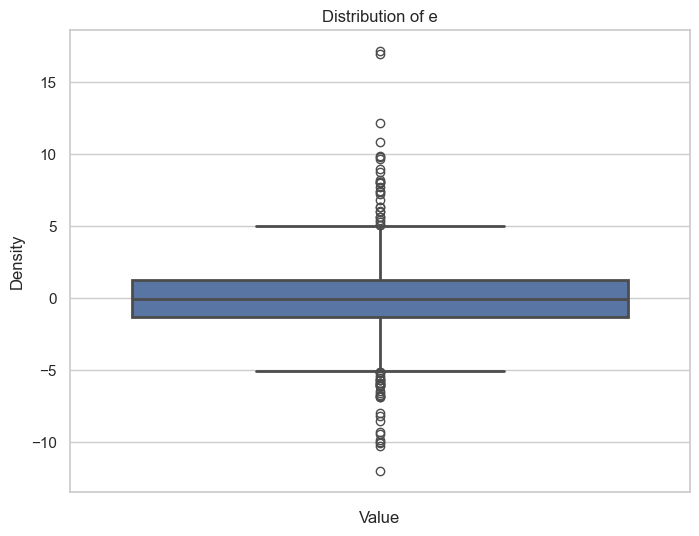

In [71]:
Plot_e(e_uni)

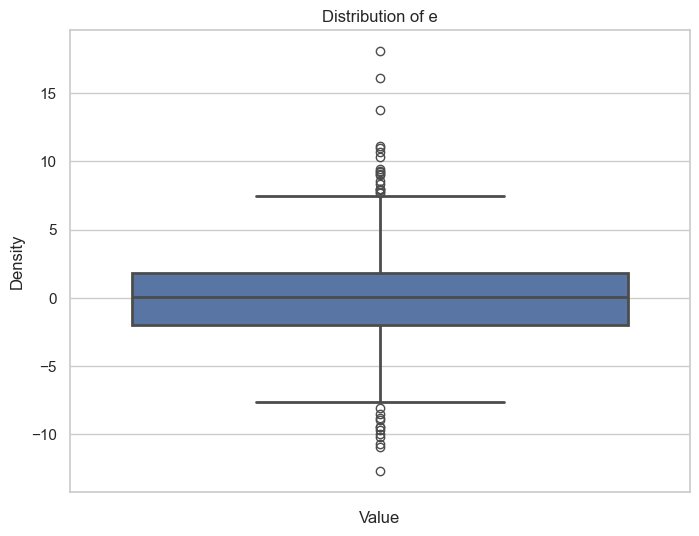

In [72]:
Plot_e(e_nor)

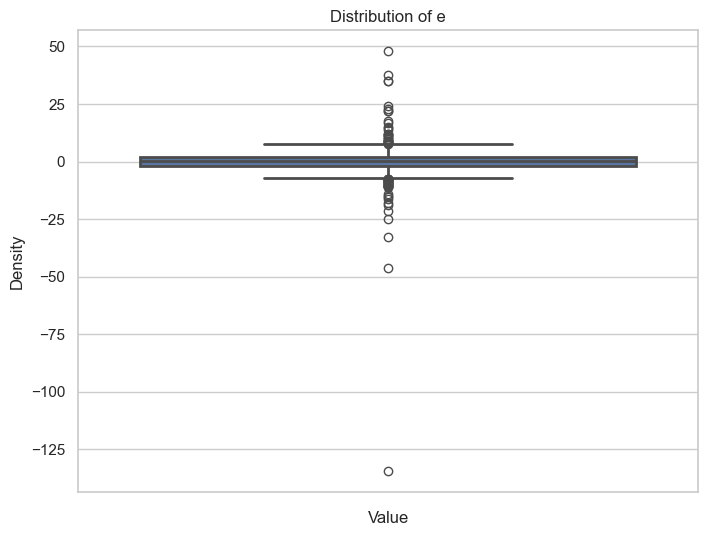

In [73]:
Plot_e(e_t)

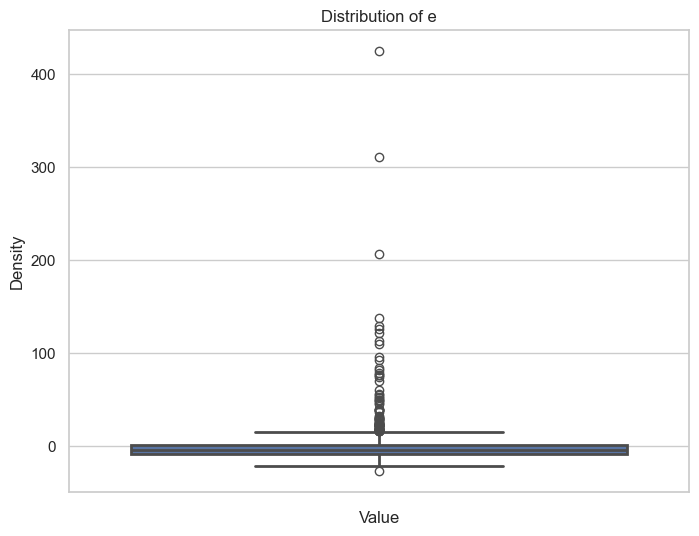

In [74]:
Plot_e(e_lognor)

## 1.2. Train Estimator

**Note:** The models in the final stage of the estimation (``model_T_final``, ``model_Y_final``) need to support sample weighting. 

If the models of choice do not support sample weights (e.g. ``sklearn.linear_model.LassoCV``), the ``econml`` packages provides a convenient wrapper for these models ``WeightedModelWrapper`` in order to allow sample weights.

In [4]:
est = DMLOrthoForest_test(
    n_trees=1000, min_leaf_size=5,
    max_depth=50,
    subsample_ratio=subsample_ratio,
    model_T=Lasso(alpha=lambda_reg),
    model_Y=Lasso(alpha=lambda_reg),
    model_T_final=WeightedLasso(alpha=lambda_reg),
    model_Y_final=WeightedLasso(alpha=lambda_reg),
    global_residualization=False,
    random_state=123
    )

To use the built-in confidence intervals constructed via Bootstrap of Little Bags, we can specify `inference="blb"` at `fit` time or leave the default `inference='auto'` which will automatically use the Bootstrap of Little Bags.

In [ ]:
est.fit(Y, T, X=X, W=W, inference="blb")

In [82]:
# Calculate treatment effects
treatment_effects = est.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   16.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.8s finished


In [83]:
# Calculate default (95%) confidence intervals for the test data
te_lower, te_upper = est.effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


In [84]:
res = est.effect_inference(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    3.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished


In [85]:
res.summary_frame().head()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,1.148,0.169,6.776,0.0,0.816,1.480
1,1.159,0.161,7.193,0.0,0.843,1.475
2,1.170,0.153,7.637,0.0,0.870,1.470
3,1.181,0.146,8.108,0.0,0.895,1.466
4,1.192,0.139,8.601,0.0,0.920,1.464


In [86]:
res.population_summary()

Similarly we can estimate effects and get confidence intervals and inference results using a `CausalForest`.

In [51]:
est2 = CausalForestDML(model_t=Lasso(alpha=lambda_reg),
                       model_y=Lasso(alpha=lambda_reg),
                       n_estimators=4000, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)
est2.tune(Y, T, X=X, W=W)
est2.fit(Y, T, X=X, W=W)
treatment_effects2 = est2.effect(X_test)
te_lower2, te_upper2 = est2.effect_interval(X_test, alpha=0.01)

## 1.3. Performance Visualization

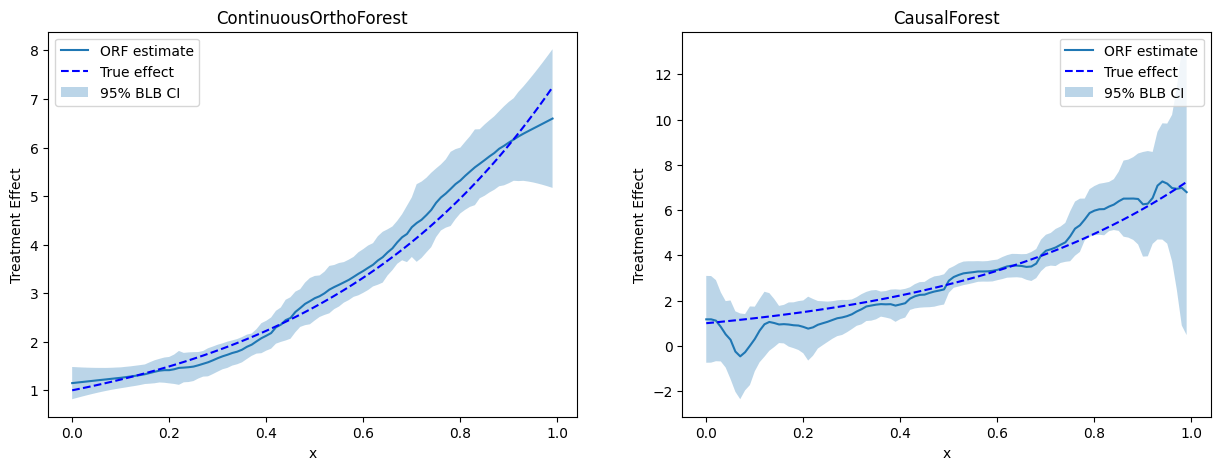

In [87]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("ContinuousOrthoForest")
plt.plot(X_test, treatment_effects, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.fill_between(X_test[:, 0], te_lower, te_upper, label="95% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("CausalForest")
plt.plot(X_test, treatment_effects2, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.fill_between(X_test[:, 0], te_lower2, te_upper2, label="95% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()